# Bitcoin LSTM Model with Tweet Volume and Sentiment

## Load libraries

In [137]:
import pandas as pd
import re
from matplotlib import pyplot
import seaborn as sns
import numpy as np
import os  # accessing directory structure


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

print(os.listdir("/"))

# set seed
np.random.seed(12345)

['$RECYCLE.BIN', '03_IntelliJ IDEA', '2019版安装教程.docx', '46-clion2020破解-无限重置插件', 'Adobe_Premiere Pro 2023', 'anaconda3', 'BaiduNetdisk', 'BaiduNetdiskDownload', 'cent browser', 'CLion 2020.1', 'CLion 2020.1pjb', 'CLionProjects', 'CLIPART', 'CloudMusic', 'CN', 'Config.Msi', 'DAUM', 'Document Themes 16', 'DouyuPCClient', 'DTL8Folder', 'DumpStack.log.tmp', 'Epic Games', 'FFOutput', 'FIRECOLUMN.jpeg', 'FIRECOLUMN1.jpeg', 'FIRECOLUMN2.jpeg', 'firegod.jpg', 'FormatFactory', 'GameDownload', 'Games', 'Git', 'Github', 'GOG Games', 'HuyaClient', 'iGame', 'InfoClient', 'JetBrains', 'kaggle', 'KDR', 'MATLAB_2016', 'Microsoft VS Code', 'MSOCache', 'Netease', 'network', 'Office16', 'Office2016简体中文64位(专业版)', 'opencv', 'pagefile.sys', 'PhotoshopCS6', 'Program Files', 'Program Files (x86)', 'Programs', 'PyCharm 2021.3', 'python', 'qqpcmgr_docpro', 'Recovery', 'Riot Games', 'Stationery', 'steam', 'System Volume Information', 'TECENT_FILES', 'Temp', 'Templates', 'Tencent', 'thunder', 'Thunder.exe', 'Thund

## Data Pre-processing

In [138]:
notclean = pd.read_csv(
    "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/LSTM/cleanprep.csv", delimiter=",", on_bad_lines="skip", engine="python", header=None
)

In [139]:
notclean.head()

,0,1,2,3,4
0,2018-07-11 19:35:15.363270,b'tj',"b""Next two weeks prob v boring (climb up to 9k...",0.007273,0.590909
1,2018-07-11 19:35:15.736769,b'Kool_Kheart',b'@Miss_rinola But you\xe2\x80\x99ve heard abo...,0.000000,0.000000
2,2018-07-11 19:35:15.744769,b'Gary Lang',b'Duplicate skilled traders automatically with...,0.625000,0.500000
3,2018-07-11 19:35:15.867339,b'Jobs in Fintech',b'Project Manager - Technical - FinTech - Cent...,0.000000,0.175000
4,2018-07-11 19:35:16.021448,b'ERC20',"b'Coinbase App Downloads Drop, Crypto Hype Fad...",0.333333,0.500000


In [140]:
# -----------------Pre-processing -------------------#

notclean.columns = ["dt", "name", "text", "polarity", "sensitivity"]

In [141]:
notclean = notclean.drop(["name", "text"], axis=1)

In [142]:
notclean.head()

,dt,polarity,sensitivity
0,2018-07-11 19:35:15.363270,0.007273,0.590909
1,2018-07-11 19:35:15.736769,0.000000,0.000000
2,2018-07-11 19:35:15.744769,0.625000,0.500000
3,2018-07-11 19:35:15.867339,0.000000,0.175000
4,2018-07-11 19:35:16.021448,0.333333,0.500000


In [143]:
notclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413001 entries, 0 to 1413000
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   dt           1413001 non-null  object 
 1   polarity     1413001 non-null  float64
 2   sensitivity  1413001 non-null  float64
dtypes: float64(2), object(1)
memory usage: 32.3+ MB


In [144]:
notclean["dt"] = pd.to_datetime(notclean["dt"])

In [145]:
notclean["DateTime"] = notclean["dt"].dt.floor("h")
notclean.head()

,dt,polarity,sensitivity,DateTime
0,2018-07-11 19:35:15.363270,0.007273,0.590909,2018-07-11 19:00:00
1,2018-07-11 19:35:15.736769,0.000000,0.000000,2018-07-11 19:00:00
2,2018-07-11 19:35:15.744769,0.625000,0.500000,2018-07-11 19:00:00
3,2018-07-11 19:35:15.867339,0.000000,0.175000,2018-07-11 19:00:00
4,2018-07-11 19:35:16.021448,0.333333,0.500000,2018-07-11 19:00:00


In [146]:
vdf = (
    notclean.groupby(pd.Grouper(key="dt", freq="H"))
    .size()
    .reset_index(name="tweet_vol")
)

In [147]:
vdf.head()

,dt,tweet_vol
0,2018-07-11 19:00:00,1747
1,2018-07-11 20:00:00,4354
2,2018-07-11 21:00:00,4432
3,2018-07-11 22:00:00,3980
4,2018-07-11 23:00:00,3830


In [148]:
vdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 302 entries, 0 to 301
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   dt         302 non-null    datetime64[ns]
 1   tweet_vol  302 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 4.8 KB


In [149]:
vdf.index = pd.to_datetime(vdf.index)
vdf = vdf.set_index("dt")

In [150]:
vdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2018-07-11 19:00:00 to 2018-07-24 08:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   tweet_vol  302 non-null    int64
dtypes: int64(1)
memory usage: 4.7 KB


In [151]:
vdf.head()

,tweet_vol
dt,
2018-07-11 19:00:00,1747
2018-07-11 20:00:00,4354
2018-07-11 21:00:00,4432
2018-07-11 22:00:00,3980
2018-07-11 23:00:00,3830


In [152]:
notclean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1413001 entries, 0 to 1413000
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   dt           1413001 non-null  datetime64[ns]
 1   polarity     1413001 non-null  float64       
 2   sensitivity  1413001 non-null  float64       
 3   DateTime     1413001 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 43.1 MB


In [153]:
notclean.index = pd.to_datetime(notclean.index)

In [154]:
notclean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1413001 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.001413
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   dt           1413001 non-null  datetime64[ns]
 1   polarity     1413001 non-null  float64       
 2   sensitivity  1413001 non-null  float64       
 3   DateTime     1413001 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 53.9 MB


In [155]:
vdf["tweet_vol"] = vdf["tweet_vol"].astype(float)

In [156]:
vdf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 302 entries, 2018-07-11 19:00:00 to 2018-07-24 08:00:00
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   tweet_vol  302 non-null    float64
dtypes: float64(1)
memory usage: 4.7 KB


In [157]:
notclean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1413001 entries, 1970-01-01 00:00:00 to 1970-01-01 00:00:00.001413
Data columns (total 4 columns):
 #   Column       Non-Null Count    Dtype         
---  ------       --------------    -----         
 0   dt           1413001 non-null  datetime64[ns]
 1   polarity     1413001 non-null  float64       
 2   sensitivity  1413001 non-null  float64       
 3   DateTime     1413001 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2)
memory usage: 53.9 MB


In [158]:
notclean.head()

,dt,polarity,sensitivity,DateTime
1970-01-01 00:00:00.000000000,2018-07-11 19:35:15.363270,0.007273,0.590909,2018-07-11 19:00:00
1970-01-01 00:00:00.000000001,2018-07-11 19:35:15.736769,0.000000,0.000000,2018-07-11 19:00:00
1970-01-01 00:00:00.000000002,2018-07-11 19:35:15.744769,0.625000,0.500000,2018-07-11 19:00:00
1970-01-01 00:00:00.000000003,2018-07-11 19:35:15.867339,0.000000,0.175000,2018-07-11 19:00:00
1970-01-01 00:00:00.000000004,2018-07-11 19:35:16.021448,0.333333,0.500000,2018-07-11 19:00:00


In [159]:
# ndf = pd.merge(notclean,vdf, how='inner',left_index=True, right_index=True)

In [160]:
notclean.head()

,dt,polarity,sensitivity,DateTime
1970-01-01 00:00:00.000000000,2018-07-11 19:35:15.363270,0.007273,0.590909,2018-07-11 19:00:00
1970-01-01 00:00:00.000000001,2018-07-11 19:35:15.736769,0.000000,0.000000,2018-07-11 19:00:00
1970-01-01 00:00:00.000000002,2018-07-11 19:35:15.744769,0.625000,0.500000,2018-07-11 19:00:00
1970-01-01 00:00:00.000000003,2018-07-11 19:35:15.867339,0.000000,0.175000,2018-07-11 19:00:00
1970-01-01 00:00:00.000000004,2018-07-11 19:35:16.021448,0.333333,0.500000,2018-07-11 19:00:00


In [161]:
df = notclean.groupby("DateTime").agg(lambda x: x.mean())

In [162]:
df["Tweet_vol"] = vdf["tweet_vol"]

In [163]:
df = df.drop(df.index[0])

In [164]:
df.head()

,dt,polarity,sensitivity,Tweet_vol
DateTime,,,,
2018-07-11 20:00:00,2018-07-11 20:27:49.510636288,0.102657,0.216148,4354.0
2018-07-11 21:00:00,2018-07-11 21:28:35.636368640,0.098004,0.218612,4432.0
2018-07-11 22:00:00,2018-07-11 22:27:44.646705152,0.096688,0.231342,3980.0
2018-07-11 23:00:00,2018-07-11 23:28:06.455850496,0.103997,0.217739,3830.0
2018-07-12 00:00:00,2018-07-12 00:28:47.975385344,0.094383,0.195256,3998.0


In [165]:
df.tail()

,dt,polarity,sensitivity,Tweet_vol
DateTime,,,,
2018-07-24 04:00:00,2018-07-24 04:27:40.946246656,0.121358,0.236000,4475.0
2018-07-24 05:00:00,2018-07-24 05:28:40.424965632,0.095163,0.216924,4808.0
2018-07-24 06:00:00,2018-07-24 06:30:52.606722816,0.088992,0.220173,6036.0
2018-07-24 07:00:00,2018-07-24 07:27:29.229673984,0.091439,0.198279,6047.0
2018-07-24 08:00:00,2018-07-24 08:07:02.674452224,0.071268,0.218217,2444.0


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 301 entries, 2018-07-11 20:00:00 to 2018-07-24 08:00:00
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   dt           301 non-null    datetime64[ns]
 1   polarity     301 non-null    float64       
 2   sensitivity  301 non-null    float64       
 3   Tweet_vol    301 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 11.8 KB


In [167]:
btcDF = pd.read_csv("https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/LSTM/btcSave2.csv", on_bad_lines="skip", engine="python")

In [168]:
btcDF["Timestamp"] = pd.to_datetime(btcDF["Timestamp"])
btcDF = btcDF.set_index(pd.DatetimeIndex(btcDF["Timestamp"]))

In [169]:
btcDF.head()

,Timestamp,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,,
2018-07-10 01:00:00,2018-07-10 01:00:00,6666.75,6683.90,6635.59,6669.73,281.73,1875693.72,6657.70
2018-07-10 02:00:00,2018-07-10 02:00:00,6662.44,6674.60,6647.00,6647.00,174.10,1160103.29,6663.38
2018-07-10 03:00:00,2018-07-10 03:00:00,6652.52,6662.82,6621.99,6632.53,231.41,1536936.22,6641.70
2018-07-10 04:00:00,2018-07-10 04:00:00,6631.17,6655.48,6625.54,6635.92,120.38,799154.77,6638.52
2018-07-10 05:00:00,2018-07-10 05:00:00,6632.81,6651.06,6627.64,6640.57,94.00,624289.31,6641.32


In [170]:
btcDF = btcDF.drop(["Timestamp"], axis=1)

In [171]:
btcDF.head()

,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
Timestamp,,,,,,,
2018-07-10 01:00:00,6666.75,6683.90,6635.59,6669.73,281.73,1875693.72,6657.70
2018-07-10 02:00:00,6662.44,6674.60,6647.00,6647.00,174.10,1160103.29,6663.38
2018-07-10 03:00:00,6652.52,6662.82,6621.99,6632.53,231.41,1536936.22,6641.70
2018-07-10 04:00:00,6631.17,6655.48,6625.54,6635.92,120.38,799154.77,6638.52
2018-07-10 05:00:00,6632.81,6651.06,6627.64,6640.57,94.00,624289.31,6641.32


In [172]:
Final_df = pd.merge(df, btcDF, how="inner", left_index=True, right_index=True)

In [173]:
Final_df.head()

,dt,polarity,sensitivity,Tweet_vol,Open,High,Low,Close,Volume (BTC),Volume (Currency),Weighted Price
2018-07-11 20:00:00,2018-07-11 20:27:49.510636288,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37,6315.33
2018-07-11 21:00:00,2018-07-11 21:28:35.636368640,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,6356.48,126.46,804221.55,6359.53
2018-07-11 22:00:00,2018-07-11 22:27:44.646705152,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87,6354.12
2018-07-11 23:00:00,2018-07-11 23:28:06.455850496,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,6368.78,81.54,519278.69,6368.23
2018-07-12 00:00:00,2018-07-12 00:28:47.975385344,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,6380.00,124.55,793560.22,6371.51


In [174]:
Final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294 entries, 2018-07-11 20:00:00 to 2018-07-24 01:00:00
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   dt                 294 non-null    datetime64[ns]
 1   polarity           294 non-null    float64       
 2   sensitivity        294 non-null    float64       
 3   Tweet_vol          294 non-null    float64       
 4   Open               294 non-null    float64       
 5   High               294 non-null    float64       
 6   Low                294 non-null    float64       
 7   Close              294 non-null    float64       
 8   Volume (BTC)       294 non-null    float64       
 9   Volume (Currency)  294 non-null    float64       
 10  Weighted Price     294 non-null    float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 27.6 KB


In [175]:
Final_df = Final_df.drop(["Weighted Price"], axis=1)

In [176]:
Final_df.head()

,dt,polarity,sensitivity,Tweet_vol,Open,High,Low,Close,Volume (BTC),Volume (Currency)
2018-07-11 20:00:00,2018-07-11 20:27:49.510636288,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37
2018-07-11 21:00:00,2018-07-11 21:28:35.636368640,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,6356.48,126.46,804221.55
2018-07-11 22:00:00,2018-07-11 22:27:44.646705152,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87
2018-07-11 23:00:00,2018-07-11 23:28:06.455850496,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,6368.78,81.54,519278.69
2018-07-12 00:00:00,2018-07-12 00:28:47.975385344,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,6380.00,124.55,793560.22


In [177]:
Final_df.columns = [
    "dt",
    "Polarity",
    "Sensitivity",
    "Tweet_vol",
    "Open",
    "High",
    "Low",
    "Close_Price",
    "Volume_BTC",
    "Volume_Dollar",
]

In [178]:
Final_df.head()

,dt,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Close_Price,Volume_BTC,Volume_Dollar
2018-07-11 20:00:00,2018-07-11 20:27:49.510636288,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,6350.00,986.73,6231532.37
2018-07-11 21:00:00,2018-07-11 21:28:35.636368640,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,6356.48,126.46,804221.55
2018-07-11 22:00:00,2018-07-11 22:27:44.646705152,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,6361.93,259.10,1646353.87
2018-07-11 23:00:00,2018-07-11 23:28:06.455850496,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,6368.78,81.54,519278.69
2018-07-12 00:00:00,2018-07-12 00:28:47.975385344,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,6380.00,124.55,793560.22


In [179]:
Final_df = Final_df[
    [
        "Polarity",
        "Sensitivity",
        "Tweet_vol",
        "Open",
        "High",
        "Low",
        "Volume_BTC",
        "Volume_Dollar",
        "Close_Price",
    ]
]

In [180]:
Final_df

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00
2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48
2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93
2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78
2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00
...,...,...,...,...,...,...,...,...,...
2018-07-23 21:00:00,0.107282,0.235636,5164.0,7746.99,7763.59,7690.16,237.63,1836633.86,7706.00
2018-07-23 22:00:00,0.094493,0.271796,4646.0,7699.13,7759.99,7690.50,63.31,489000.25,7750.09
2018-07-23 23:00:00,0.074246,0.231640,4455.0,7754.57,7777.00,7715.45,280.46,2173424.81,7722.32
2018-07-24 00:00:00,0.080870,0.219367,3862.0,7722.95,7730.61,7690.17,496.48,3830571.66,7719.62


## Exploratory Analysis

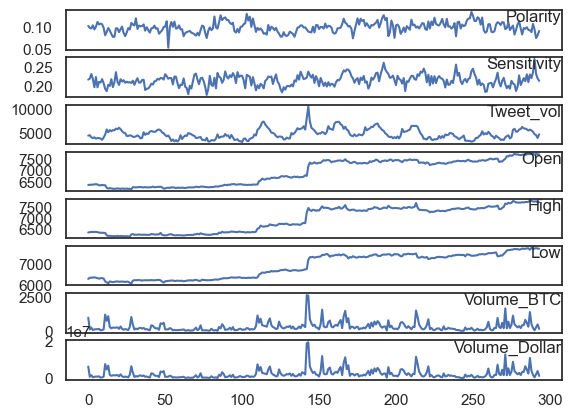

In [182]:
# --------------Analysis----------------------------#

values = Final_df.values
groups = [0, 1, 2, 3, 4, 5, 6, 7]
i = 1
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(Final_df.columns[group], y=0.5, loc="right")
    i += 1
pyplot.show()

In [183]:
Final_df["Volume_BTC"].max()

2640.49

In [184]:
Final_df["Volume_Dollar"].max()

19126407.89

In [185]:
Final_df["Volume_BTC"].sum()

96945.04000000001

In [186]:
Final_df["Volume_Dollar"].sum()

684457140.05

In [187]:
Final_df["Tweet_vol"].max()

10452.0

In [188]:
Final_df.describe()

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,2.940000e+02,294.000000
mean,0.099534,0.214141,4691.119048,6915.349388,6946.782925,6889.661054,329.745034,2.328086e+06,6920.150000
std,0.012114,0.014940,1048.922706,564.467674,573.078843,559.037540,344.527625,2.508128e+06,565.424866
min,0.051695,0.174330,2998.000000,6149.110000,6173.610000,6072.000000,22.000000,1.379601e+05,6149.110000
25%,0.091489,0.203450,3878.750000,6285.077500,6334.942500,6266.522500,129.230000,8.412214e+05,6283.497500
50%,0.099198,0.214756,4452.000000,7276.845000,7311.380000,7245.580000,223.870000,1.607008e+06,7281.975000
75%,0.106649,0.223910,5429.750000,7422.957500,7457.202500,7396.427500,385.135000,2.662185e+06,7424.560000
max,0.135088,0.271796,10452.000000,7754.570000,7800.000000,7724.500000,2640.490000,1.912641e+07,7750.090000


In [189]:
cor = Final_df.corr()
cor

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
Polarity,1.000000,0.380350,-0.167573,0.179056,0.176277,0.180088,-0.062868,-0.052646,0.178456
Sensitivity,0.380350,1.000000,0.053903,0.194763,0.200611,0.190222,0.097124,0.112425,0.193203
Tweet_vol,-0.167573,0.053903,1.000000,0.237185,0.262207,0.234330,0.541112,0.545850,0.250448
Open,0.179056,0.194763,0.237185,1.000000,0.997128,0.998799,0.217478,0.277600,0.997217
High,0.176277,0.200611,0.262207,0.997128,1.000000,0.996650,0.270551,0.329816,0.998816
Low,0.180088,0.190222,0.234330,0.998799,0.996650,1.000000,0.202895,0.263863,0.998058
Volume_BTC,-0.062868,0.097124,0.541112,0.217478,0.270551,0.202895,1.000000,0.995873,0.243875
Volume_Dollar,-0.052646,0.112425,0.545850,0.277600,0.329816,0.263863,0.995873,1.000000,0.303347
Close_Price,0.178456,0.193203,0.250448,0.997217,0.998816,0.998058,0.243875,0.303347,1.000000


In [190]:
Top_Vol = Final_df["Volume_BTC"].nlargest(10)
Top_Vol

2018-07-17 18:00:00    2640.49
2018-07-17 19:00:00    2600.32
2018-07-23 03:00:00    1669.28
2018-07-18 04:00:00    1576.15
2018-07-20 17:00:00    1510.00
2018-07-18 19:00:00    1490.02
2018-07-23 19:00:00    1396.32
2018-07-12 07:00:00    1211.64
2018-07-16 10:00:00    1147.69
2018-07-23 08:00:00    1135.38
Name: Volume_BTC, dtype: float64

In [191]:
Top_Sen = Final_df["Sensitivity"].nlargest(10)
Top_Sen

2018-07-23 22:00:00    0.271796
2018-07-19 20:00:00    0.262048
2018-07-21 19:00:00    0.256952
2018-07-20 22:00:00    0.246046
2018-07-22 06:00:00    0.245820
2018-07-19 19:00:00    0.244655
2018-07-19 21:00:00    0.244215
2018-07-18 20:00:00    0.243534
2018-07-18 21:00:00    0.243422
2018-07-18 18:00:00    0.241287
Name: Sensitivity, dtype: float64

In [192]:
Top_Pol = Final_df["Polarity"].nlargest(10)
Top_Pol

2018-07-22 05:00:00    0.135088
2018-07-16 03:00:00    0.130634
2018-07-19 20:00:00    0.127696
2018-07-15 10:00:00    0.127469
2018-07-22 06:00:00    0.126299
2018-07-15 06:00:00    0.124505
2018-07-16 05:00:00    0.124210
2018-07-22 09:00:00    0.122784
2018-07-15 13:00:00    0.122411
2018-07-22 12:00:00    0.122021
Name: Polarity, dtype: float64

In [193]:
Top_Tweet = Final_df["Tweet_vol"].nlargest(10)
Top_Tweet

2018-07-17 19:00:00    10452.0
2018-07-17 18:00:00     7995.0
2018-07-17 20:00:00     7354.0
2018-07-16 14:00:00     7280.0
2018-07-18 15:00:00     7222.0
2018-07-18 14:00:00     7209.0
2018-07-18 13:00:00     7171.0
2018-07-16 13:00:00     7133.0
2018-07-19 16:00:00     6886.0
2018-07-18 12:00:00     6844.0
Name: Tweet_vol, dtype: float64

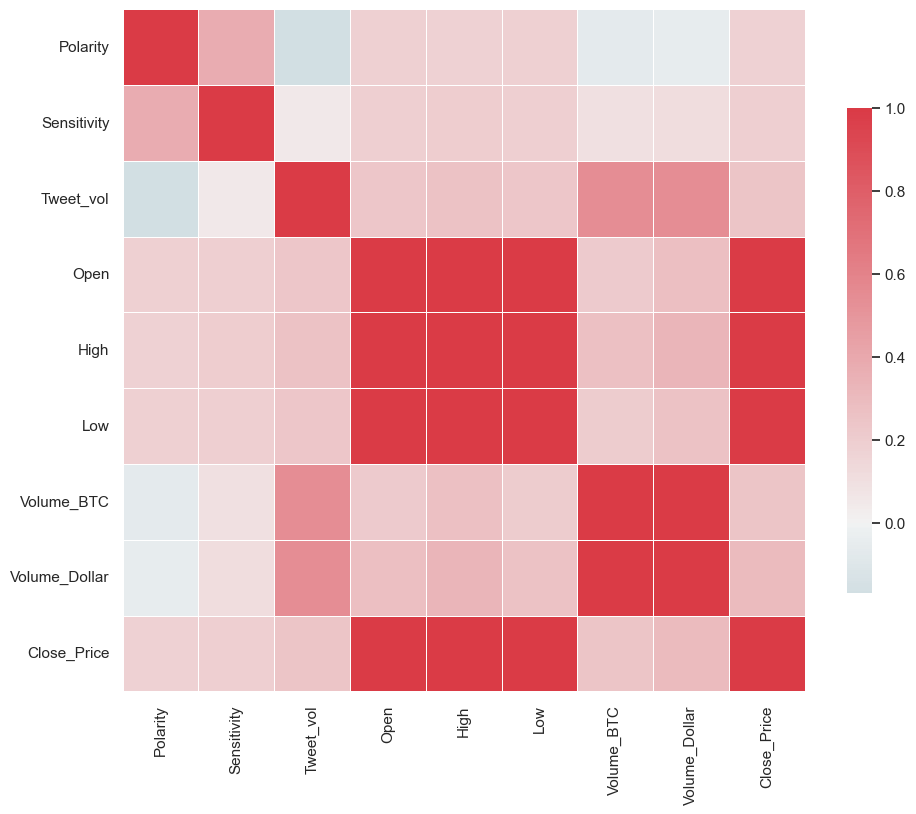

In [194]:
import matplotlib.pyplot as plt

sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(
    cor,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
)
plt.show()

In [195]:
# sns Heatmap for Hour x volume
# Final_df['time']=Final_df.index.time()
Final_df["time"] = Final_df.index.to_series().apply(lambda x: x.strftime("%X"))

In [196]:
Final_df.head()

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price,time
2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00,20:00:00
2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48,21:00:00
2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93,22:00:00
2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78,23:00:00
2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00,00:00:00


In [197]:
hour_df = Final_df

In [198]:
hour_df = hour_df.groupby("time").agg(lambda x: x.mean())

In [199]:
hour_df

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
time,,,,,,,,,
00:00:00,0.090298,0.211771,3976.384615,6930.237692,6958.360769,6900.588462,322.836154,2.228120e+06,6935.983077
01:00:00,0.099596,0.211714,4016.615385,6935.140769,6963.533846,6894.772308,318.415385,2.243338e+06,6933.794615
02:00:00,0.102724,0.204445,3824.083333,6868.211667,6889.440000,6842.588333,158.836667,1.105651e+06,6870.695833
03:00:00,0.105586,0.214824,3791.666667,6870.573333,6909.675833,6855.316667,328.811667,2.385733e+06,6888.139167
04:00:00,0.103095,0.208516,3822.916667,6887.420000,6911.649167,6872.603333,271.692500,1.949230e+06,6890.985000
05:00:00,0.108032,0.215058,3904.166667,6891.468333,6911.175833,6869.017500,213.315000,1.524601e+06,6890.451667
06:00:00,0.104412,0.210424,3760.250000,6889.327500,6907.070833,6868.484167,183.329167,1.281427e+06,6891.371667
07:00:00,0.100942,0.209435,4056.000000,6891.645833,6908.654167,6858.290833,329.882500,2.263694e+06,6878.757500
08:00:00,0.099380,0.210113,5095.583333,6878.635833,6903.660833,6851.435833,368.109167,2.616314e+06,6885.867500


In [200]:
hour_df.head()

,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
time,,,,,,,,,
00:00:00,0.090298,0.211771,3976.384615,6930.237692,6958.360769,6900.588462,322.836154,2.228120e+06,6935.983077
01:00:00,0.099596,0.211714,4016.615385,6935.140769,6963.533846,6894.772308,318.415385,2.243338e+06,6933.794615
02:00:00,0.102724,0.204445,3824.083333,6868.211667,6889.440000,6842.588333,158.836667,1.105651e+06,6870.695833
03:00:00,0.105586,0.214824,3791.666667,6870.573333,6909.675833,6855.316667,328.811667,2.385733e+06,6888.139167
04:00:00,0.103095,0.208516,3822.916667,6887.420000,6911.649167,6872.603333,271.692500,1.949230e+06,6890.985000


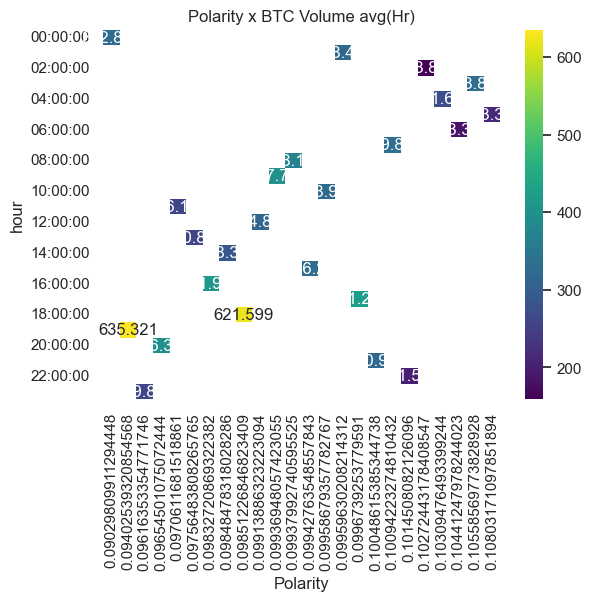

In [201]:
# sns Hourly Heatmap
hour_df["hour"] = hour_df.index
result = hour_df.pivot(index="hour", columns="Polarity", values="Volume_BTC")
sns.heatmap(result, annot=True, fmt="g", cmap="viridis")
plt.title("Polarity x BTC Volume avg(Hr)")
plt.show()

# sns daily heatmap?

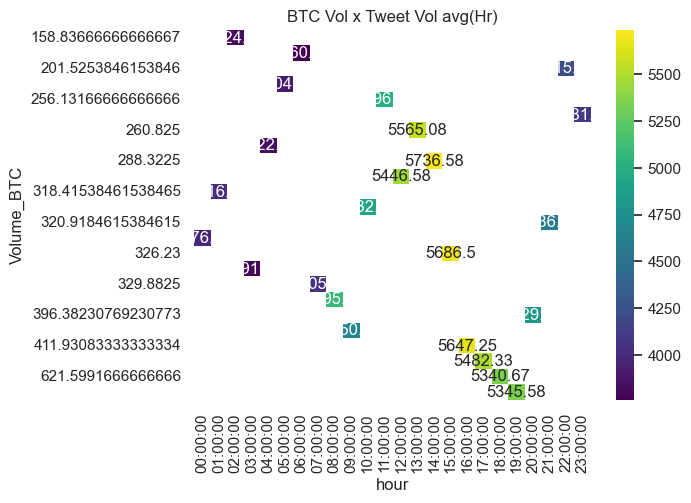

In [202]:
hour_df["hour"] = hour_df.index
result = hour_df.pivot(index="Volume_BTC", columns="hour", values="Tweet_vol")
sns.heatmap(result, annot=True, fmt="g", cmap="viridis")
plt.title("BTC Vol x Tweet Vol avg(Hr)")
plt.show()

In [203]:
# ----------------End Analysis------------------------#

In [204]:
# ---------------- LSTM Prep ------------------------#

In [205]:
df = Final_df

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 294 entries, 2018-07-11 20:00:00 to 2018-07-24 01:00:00
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Polarity       294 non-null    float64
 1   Sensitivity    294 non-null    float64
 2   Tweet_vol      294 non-null    float64
 3   Open           294 non-null    float64
 4   High           294 non-null    float64
 5   Low            294 non-null    float64
 6   Volume_BTC     294 non-null    float64
 7   Volume_Dollar  294 non-null    float64
 8   Close_Price    294 non-null    float64
 9   time           294 non-null    object 
dtypes: float64(9), object(1)
memory usage: 33.4+ KB


In [207]:
df = df.drop(["Open", "High", "Low", "Volume_Dollar"], axis=1)
df.head()

,Polarity,Sensitivity,Tweet_vol,Volume_BTC,Close_Price,time
2018-07-11 20:00:00,0.102657,0.216148,4354.0,986.73,6350.00,20:00:00
2018-07-11 21:00:00,0.098004,0.218612,4432.0,126.46,6356.48,21:00:00
2018-07-11 22:00:00,0.096688,0.231342,3980.0,259.10,6361.93,22:00:00
2018-07-11 23:00:00,0.103997,0.217739,3830.0,81.54,6368.78,23:00:00
2018-07-12 00:00:00,0.094383,0.195256,3998.0,124.55,6380.00,00:00:00


In [208]:
df = df[["Close_Price", "Polarity", "Sensitivity", "Tweet_vol", "Volume_BTC"]]
df.head()

,Close_Price,Polarity,Sensitivity,Tweet_vol,Volume_BTC
2018-07-11 20:00:00,6350.00,0.102657,0.216148,4354.0,986.73
2018-07-11 21:00:00,6356.48,0.098004,0.218612,4432.0,126.46
2018-07-11 22:00:00,6361.93,0.096688,0.231342,3980.0,259.10
2018-07-11 23:00:00,6368.78,0.103997,0.217739,3830.0,81.54
2018-07-12 00:00:00,6380.00,0.094383,0.195256,3998.0,124.55


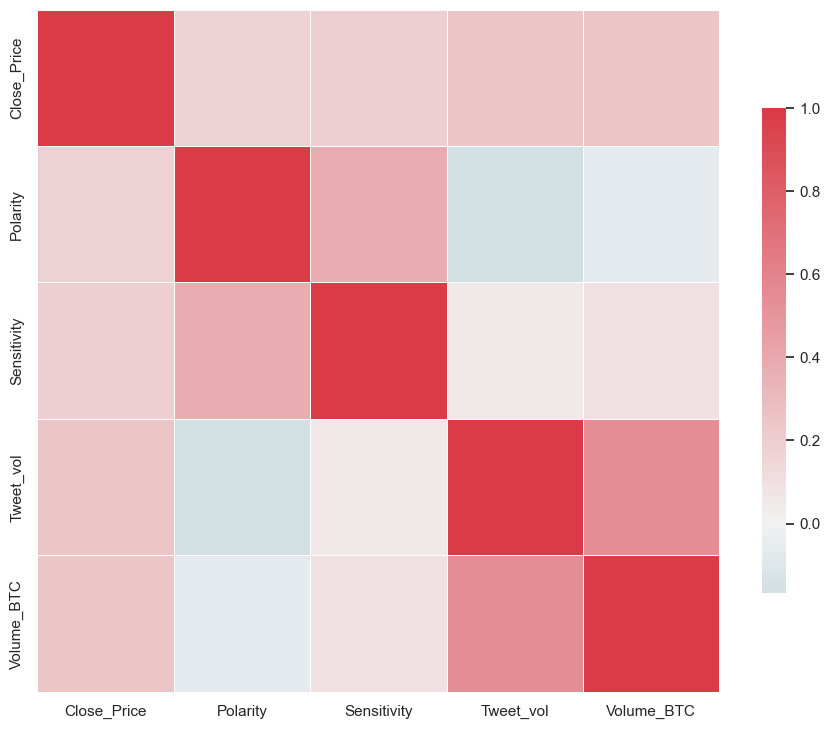

In [209]:
cor = df.corr()
import matplotlib.pyplot as plt

sns.set(style="white")
f, ax = plt.subplots(figsize=(11, 9))

cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(
    cor,
    cmap=cmap,
    vmax=1,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.7},
)
plt.show()

## LSTM Model

In [210]:
from math import sqrt
from numpy import concatenate
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot

from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM


# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [("var%d(t-%d)" % (j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [("var%d(t)" % (j + 1)) for j in range(n_vars)]
        else:
            names += [("var%d(t+%d)" % (j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [211]:
values = df.values
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df = df[["Close_Price", "Polarity", "Sensitivity", "Tweet_vol", "Volume_BTC"]]
df.head()

,Close_Price,Polarity,Sensitivity,Tweet_vol,Volume_BTC
2018-07-11 20:00:00,6350.00,0.102657,0.216148,4354.0,986.73
2018-07-11 21:00:00,6356.48,0.098004,0.218612,4432.0,126.46
2018-07-11 22:00:00,6361.93,0.096688,0.231342,3980.0,259.10
2018-07-11 23:00:00,6368.78,0.103997,0.217739,3830.0,81.54
2018-07-12 00:00:00,6380.00,0.094383,0.195256,3998.0,124.55


In [212]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [213]:
n_hours = 3  # adding 3 hours lags creating number of observations
n_features = 5  # Features in the dataset.
n_obs = n_hours * n_features

In [214]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.125479,0.611105,0.429055,0.181916,0.368430,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738
4,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164
5,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637
6,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561
7,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561,0.111101,0.649855,0.365349,0.111752,0.053607


In [215]:
reframed.drop(reframed.columns[-4], axis=1)
reframed.head()

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var1(t-2),var2(t-2),var3(t-2),var4(t-2),var5(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
3,0.125479,0.611105,0.429055,0.181916,0.368430,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738
4,0.129527,0.555312,0.454335,0.192380,0.039893,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164
5,0.132931,0.539534,0.584943,0.131741,0.090548,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637
6,0.137210,0.627175,0.445375,0.111618,0.022738,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561
7,0.144218,0.511893,0.214693,0.134156,0.039164,0.135117,0.589271,0.500135,0.095922,0.045637,0.111700,0.722717,0.212514,0.113362,0.045561,0.111101,0.649855,0.365349,0.111752,0.053607


In [216]:
print(reframed.head())

   var1(t-3)  var2(t-3)  var3(t-3)  var4(t-3)  var5(t-3)  var1(t-2)   
3   0.125479   0.611105   0.429055   0.181916   0.368430   0.129527  \
4   0.129527   0.555312   0.454335   0.192380   0.039893   0.132931   
5   0.132931   0.539534   0.584943   0.131741   0.090548   0.137210   
6   0.137210   0.627175   0.445375   0.111618   0.022738   0.144218   
7   0.144218   0.511893   0.214693   0.134156   0.039164   0.135117   

   var2(t-2)  var3(t-2)  var4(t-2)  var5(t-2)  var1(t-1)  var2(t-1)   
3   0.555312   0.454335   0.192380   0.039893   0.132931   0.539534  \
4   0.539534   0.584943   0.131741   0.090548   0.137210   0.627175   
5   0.627175   0.445375   0.111618   0.022738   0.144218   0.511893   
6   0.511893   0.214693   0.134156   0.039164   0.135117   0.589271   
7   0.589271   0.500135   0.095922   0.045637   0.111700   0.722717   

   var3(t-1)  var4(t-1)  var5(t-1)   var1(t)   var2(t)   var3(t)   var4(t)   
3   0.584943   0.131741   0.090548  0.137210  0.627175  0.445375  0.

In [217]:
values = reframed.values
n_train_hours = 200
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape

(200, 20)

In [218]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [219]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(200, 3, 5) (200,) (91, 3, 5) (91,)


In [220]:
# design network
model = Sequential()
model.add(LSTM(5, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss="mae", optimizer="adam")
# fit network
history = model.fit(
    train_X,
    train_y,
    epochs=50,
    batch_size=6,
    validation_data=(test_X, test_y),
    verbose=2,
    shuffle=False,
    validation_split=0.2,
)

Epoch 1/50
34/34 - 3s - loss: 0.2547 - val_loss: 0.6327 - 3s/epoch - 79ms/step
Epoch 2/50
34/34 - 0s - loss: 0.2190 - val_loss: 0.5658 - 194ms/epoch - 6ms/step
Epoch 3/50
34/34 - 0s - loss: 0.2099 - val_loss: 0.5187 - 212ms/epoch - 6ms/step
Epoch 4/50
34/34 - 0s - loss: 0.1882 - val_loss: 0.4559 - 207ms/epoch - 6ms/step
Epoch 5/50
34/34 - 0s - loss: 0.1617 - val_loss: 0.3725 - 192ms/epoch - 6ms/step
Epoch 6/50
34/34 - 0s - loss: 0.1316 - val_loss: 0.2751 - 201ms/epoch - 6ms/step
Epoch 7/50
34/34 - 0s - loss: 0.0985 - val_loss: 0.1715 - 230ms/epoch - 7ms/step
Epoch 8/50
34/34 - 0s - loss: 0.0694 - val_loss: 0.1069 - 199ms/epoch - 6ms/step
Epoch 9/50
34/34 - 0s - loss: 0.0595 - val_loss: 0.1018 - 182ms/epoch - 5ms/step
Epoch 10/50
34/34 - 0s - loss: 0.0517 - val_loss: 0.0893 - 191ms/epoch - 6ms/step
Epoch 11/50
34/34 - 0s - loss: 0.0496 - val_loss: 0.0819 - 193ms/epoch - 6ms/step
Epoch 12/50
34/34 - 0s - loss: 0.0463 - val_loss: 0.0754 - 197ms/epoch - 6ms/step
Epoch 13/50
34/34 - 0s - lo

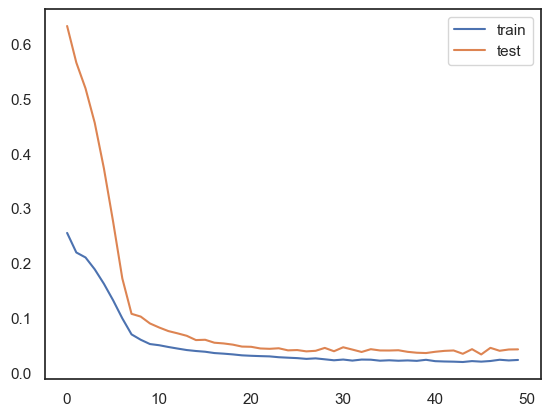

In [221]:
# plot history
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="test")
plt.legend()
plt.show()

In [ ]:
def predict(model, date_train, X_train, future_steps, ds):
    # Extracting dates
    dates = pd.date_range(list(date_train)[-1], periods=future, freq="1d").tolist()
    # use the last future steps from X_train
    predicted = model.predict(X_train[-future_steps:])
    predicted = np.repeat(predicted, ds.shape[1], axis=-1)
    nsamples, nx, ny = predicted.shape
    predicted = predicted.reshape((nsamples, nx * ny))

    return predicted, dates


def output_preparation(
    forecasting_dates, predictions, date_column="date", predicted_column="Volume USDT"
):
    dates = []
    for date in forecasting_dates:
        dates.append(date.date())
    predicted_df = pd.DataFrame(columns=[date_column, predicted_column])
    predicted_df[date_column] = pd.to_datetime(dates)
    predicted_df[predicted_column] = predictions
    return predicted_df


def results(
    df, lookback, future, scaler, col, X_train, y_train, df_train, date_train, model
):
    predictions, forecasting_dates = predict(model, date_train, X_train, future, df)
    results = output_preparation(forecasting_dates, predictions)
    print(results.head())

In [226]:
# if you need a model trained, you can use this cell
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import get_file

model_url = "https://static-1300131294.cos.ap-shanghai.myqcloud.com/data/deep-learning/LSTM/LSTM_model.h5"
model_path = get_file("LSTM_model.h5", model_url)
LSTM_model = load_model(model_path)

32208/32208 [==============================] - 0s 1us/step


In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape(
    (
        test_X.shape[0],
        n_hours * n_features,
    )
)
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -4:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -4:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:, 0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print("Test MSE: %.3f" % mse)
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print("Test RMSE: %.3f" % rmse)

3/3 [==============================] - 0s 2ms/step
Test MSE: 12919.827
Test RMSE: 113.665


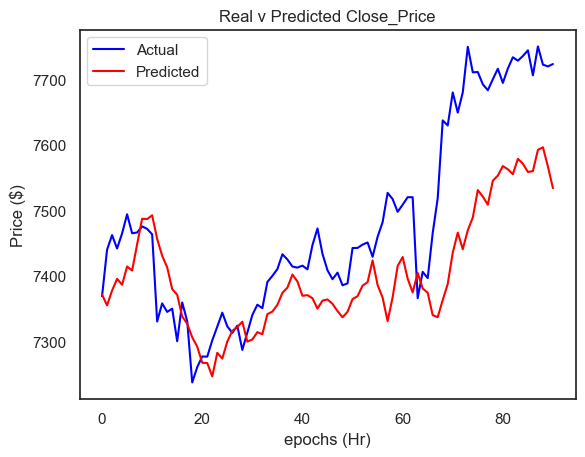

In [ ]:
plt.title("Real v Predicted Close_Price")
plt.ylabel("Price ($)")
plt.xlabel("epochs (Hr)")

actual_values = inv_y
predicted_values = inv_yhat

# plot
plt.plot(actual_values, label="Actual", color="blue")
plt.plot(predicted_values, label="Predicted", color="red")

# set title and label
plt.title("Real v Predicted Close_Price")
plt.ylabel("Price ($)")
plt.xlabel("epochs (Hr)")

# show
plt.legend()
plt.show()
plt.show()

# Acknowledgements

Thanks to [Paul Simpson](https://www.kaggle.com/paul92s) for creating [Bitcoin Lstm Model with Tweet Volume and Sentiment](https://www.kaggle.com/code/paul92s/bitcoin-lstm-model-with-tweet-volume-and-sentiment). It inspires the majority of the content in this chapter.